In [1]:
import os

os.chdir("..")

In [2]:
# Use GPU
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3,4,5,6,7'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from tqdm.auto import tqdm
import warnings
import random

# Evaluation
from sklearn.metrics import (
    f1_score,
    classification_report,
    confusion_matrix,
    make_scorer
)

# Other
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from skmultilearn.model_selection import IterativeStratification

# Classifiers
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Transformers
import torch
import transformers 
from transformers import ReformerTokenizerFast, ReformerModel

warnings.filterwarnings("ignore")

from src.models.evaluation import evaluation
from src.data.iterative_train_test_split import iterative_train_test_split

In [4]:
pd.set_option("display.max_rows", 5)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

In [5]:
# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

## 1. Load and transform data

In [6]:
# Load data
df = pd.read_pickle("data/processed/reports_tokenized.p")
df

,ID,Identifier,Company_Name,ISIN,Ticker,Country_of_Exchange,Financial_Period_Absolute,Financial_Period_Relative,CSR_URL,SDG_1,SDG_2,SDG_3,SDG_4,SDG_5,SDG_6,SDG_7,SDG_8,SDG_9,SDG_10,SDG_11,SDG_12,SDG_13,SDG_14,SDG_15,SDG_16,SDG_17,CSR_Filename,CSR_Text,CSR_Text_clean,CSR_Text_tokenized
0,0,888.L,888 Holdings PLC,GI000A0F6407,888,United Kingdom,2020,FY0,https://corporate.888.com/wp-content/uploads/2021/04/2020-Annual-Report.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,False,True,False,0_888.L_2020.pdf,888 HOLDINGS PLC\n\nANNUAL REPORT & ACCOUNTS 2020\n\n A YEAR OF \nSTRONG GROWTH \n\n888 IS ONE ...,888 ORG ANNUAL REPORT & ACCOUNTS 2020 A YEAR OF STRONG GROWTH ORG IS ONE OF THE WORLDS LEADING O...,org annual report account year strong growth org one world leading online betting gaming company...
1,1,A.N,Agilent Technologies Inc,US00846U1016,A,United States of America,2020,FY0,https://www.agilent.com/about/companyinfo/sustainability/Agilent-Report-CSR-2020.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,True,NaN,True,True,False,1_A.N_2020.pdf,Delivering on \nour Promises\n\n2020 Corporate Social Responsibility Report\n\n1\n\n Letter fro...,Delivering on our Promises 2020 Corporate ORG 1 Letter from the President Stakeholder engagement...,delivering promise corporate org letter president stakeholder engagement environment table conte...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8101,8101,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2016,FY-4,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2016.pdf,False,False,True,True,True,True,True,True,False,NaN,False,True,False,NaN,False,True,False,12676_ZBH.N_2016.pdf,E N V I R O N M E N T A L \n\n \n\nS O C I A L \n\nG O V E R N A N C E\n\nSustainability \nRep...,E N V I R O N M E N T A L S O C I A L G O V E R N A N C E Sustainability Report 2016 T A B L E O...,sustainability report company profile corporate overview purpose mission value sustainability co...
8102,8102,ZBH.N,Zimmer Biomet Holdings Inc,US98956P1021,ZBH,United States of America,2015,FY-5,https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/z/NYSE_ZBH_2015.pdf,False,False,True,True,False,True,True,False,False,NaN,False,True,False,NaN,False,False,False,12677_ZBH.N_2015.pdf,E N V I R O N M E N T A L \n\n \n\nS O C I A L \n\nG O V E R N A N C E\n\nSustainability \nRep...,E N V I R O N M E N T A L S O C I A L G O V E R N A N C E Sustainability Report 2015 Investing n...,sustainability report investing future world letter ceo stakeholder company profile corporate ov...


In [7]:
# Transform labels to numpy array: Exclude SDGs 2 and 9 (too few aligned examples) and 10 and 14 (no mapping) -> 13 labels left
labels = [
    "SDG_1",
    "SDG_3",
    "SDG_4",
    "SDG_5",
    "SDG_6",
    "SDG_7",
    "SDG_8",
    "SDG_11",
    "SDG_12",
    "SDG_13",
    "SDG_15",
    "SDG_16",
    "SDG_17",
]
Y = df[labels].to_numpy().astype(int)

In [8]:
# Split into 80% training and 20% test data (stratified for multi-label, adapted to work with df column)

np.random.seed(7)

X_train, Y_train, X_test, Y_test = iterative_train_test_split(df['CSR_Text_clean'], Y, test_size=0.2)

## 2. Compute embeddings with pre-trained Reformer model

In [9]:
# Use GPU
# torch.cuda.empty_cache()
device = torch.device('cuda:4') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=4)

In [10]:
# Load model and tokenizer
model = ReformerModel.from_pretrained("google/reformer-crime-and-punishment").to(device)
tokenizer = ReformerTokenizerFast.from_pretrained("google/reformer-crime-and-punishment")

Some weights of the model checkpoint at google/reformer-crime-and-punishment were not used when initializing ReformerModel: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing ReformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ReformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ReformerModel were not initialized from the model checkpoint at google/reformer-crime-and-punishment and are newly initialized: ['reformer.encoder.layers.1.attention.self_attention.mask_value_float32', 'reformer.encoder.layers.3.attention.self_attention.mask_value_float32', 'reformer.encoder.layers.1.attention.self_attention.self_

In [11]:
# Inference (use GPU)

# Training data

input_data = list(X_train)
outputs_train = np.zeros((len(input_data), 512))
i = 0
for sentence in tqdm(input_data):
    # Tokenize 
    tokenized_sentence = tokenizer(sentence, max_length=524288, truncation=True, return_tensors="pt") 
    with torch.no_grad():
        # Compute embeddings for batch
        outputs = model(input_ids=tokenized_sentence['input_ids'].to(device), 
                        attention_mask=tokenized_sentence['attention_mask'].to(device))
        last_hidden_states = outputs.last_hidden_state
    # Store [CLS] tokens
    outputs_train[i:i+1] = last_hidden_states[0][0,:].cpu().numpy()
    i += 1

# Test data
input_data = list(X_test)
outputs_test = np.zeros((len(input_data), 512))
i = 0
for sentence in tqdm(input_data):
    # Tokenize 
    tokenized_sentence = tokenizer(sentence, max_length=524288, truncation=True, return_tensors="pt") 
    with torch.no_grad():
        # Compute embeddings for batch
        outputs = model(input_ids=tokenized_sentence['input_ids'].to(device), 
                        attention_mask=tokenized_sentence['attention_mask'].to(device))
        last_hidden_states = outputs.last_hidden_state
    # Store [CLS] tokens
    outputs_test[i:i+1] = last_hidden_states[0][0,:].cpu().numpy()
    i += 1

  0%|          | 0/6224 [00:00<?, ?it/s]

  0%|          | 0/1879 [00:00<?, ?it/s]

## 3. Classification with balanced weights

### 3.1. Logistic Regression

In [12]:
np.random.seed(7)

# Pipeline
pipeline = Pipeline([
    ('clf', OneVsRestClassifier(LogisticRegression(class_weight="balanced")))
])
    
# Parameters to test in Grid Search
parameters = {
    'clf__estimator__C': [0.1, 1, 10] # Inverse of regularization strength, smaller values specify stronger regularization
}

# Use stratified sampling in each iteration
stratified_k_fold_cv = IterativeStratification(n_splits=5, order=1)
# Optimize for macro F1-score
scorer = make_scorer(f1_score, average="macro")

# Grid Search
grid_lr = GridSearchCV(pipeline, parameters, cv=stratified_k_fold_cv, scoring=scorer, n_jobs=8, verbose=3)
grid_lr.fit(outputs_train, Y_train)

# Print results
print("Best Parameters: {}".format(grid_lr.best_params_))
print("Mean cross-validated F1-score of the best estimator: {}".format(grid_lr.best_score_))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Fitting 5 folds for each of 3 candidates, totalling 15 fits
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENI

/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

Best Parameters: {'clf__estimator__C': 10}
Mean cross-validated F1-score of the best estimator: 0.47097155241269634


              precision    recall  f1-score   support

           0       0.12      0.80      0.20       205
           1       0.85      0.17      0.29      1483
           2       0.76      0.79      0.77      1435
           3       0.71      0.22      0.33      1311
           4       0.76      0.83      0.79      1411
           5       0.72      0.25      0.37      1309
           6       0.67      0.21      0.32      1227
           7       0.11      0.80      0.20       199
           8       0.82      0.79      0.81      1528
           9       0.62      0.86      0.72      1144
          10       0.36      0.24      0.29       582
          11       0.67      0.22      0.33      1251
          12       0.11      0.80      0.20       199

   micro avg       0.51      0.49      0.50     13284
   macro avg       0.56      0.54      0.43     13284
weighted avg       0.69      0.49      0.51     13284
 samples avg       0.46      0.49      0.45     13284



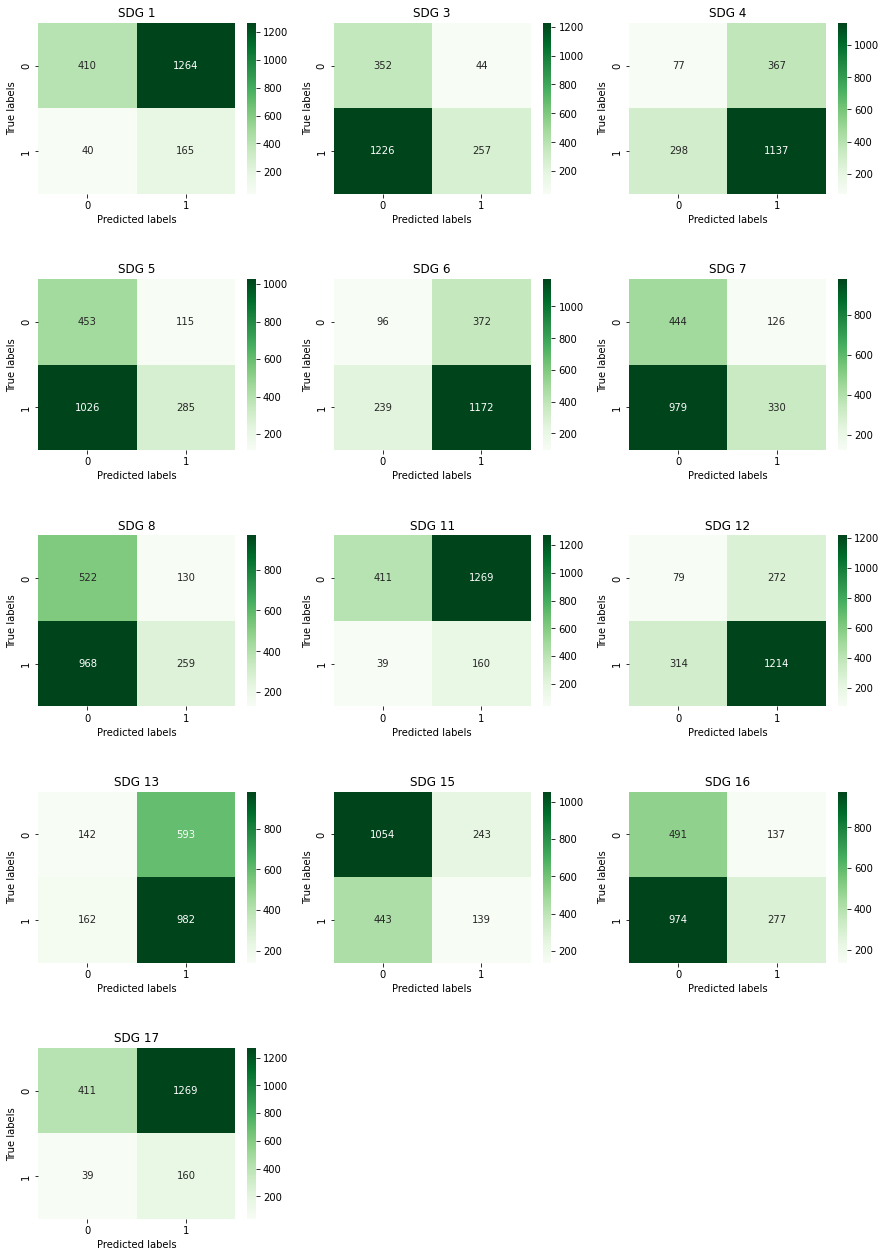

In [13]:
evaluation(grid_lr, outputs_test, Y_test)

### 3.2. Linear SVM

In [14]:
np.random.seed(7)

# Pipeline
pipeline = Pipeline([
    ('clf', OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced")))
])
    
# Parameters to test in Grid Search
parameters = {
    'clf__estimator__C': [0.1, 1, 10] # Inverse of regularization strength, smaller values specify stronger regularization
}

# Use stratified sampling in each iteration
stratified_k_fold_cv = IterativeStratification(n_splits=5, order=1)
# Optimize for macro F1-score
scorer = make_scorer(f1_score, average="macro")

# Grid Search
grid_svm = GridSearchCV(pipeline, parameters, cv=stratified_k_fold_cv, scoring=scorer, n_jobs=8, verbose=3)
grid_svm.fit(outputs_train, Y_train)

# Print results
print("Best Parameters: {}".format(grid_svm.best_params_))
print("Mean cross-validated F1-score of the best estimator: {}".format(grid_svm.best_score_))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Parameters: {'clf__estimator__C': 0.1}
Mean cross-validated F1-score of the best estimator: 0.46412866226504923


              precision    recall  f1-score   support

           0       0.12      0.80      0.20       205
           1       0.86      0.17      0.29      1483
           2       0.76      0.79      0.77      1435
           3       0.71      0.22      0.33      1311
           4       0.76      0.83      0.79      1411
           5       0.72      0.25      0.37      1309
           6       0.67      0.21      0.32      1227
           7       0.11      0.80      0.20       199
           8       0.82      0.79      0.81      1528
           9       0.62      0.86      0.72      1144
          10       0.37      0.24      0.29       582
          11       0.67      0.22      0.33      1251
          12       0.11      0.80      0.20       199

   micro avg       0.51      0.49      0.50     13284
   macro avg       0.56      0.54      0.43     13284
weighted avg       0.69      0.49      0.51     13284
 samples avg       0.46      0.49      0.45     13284



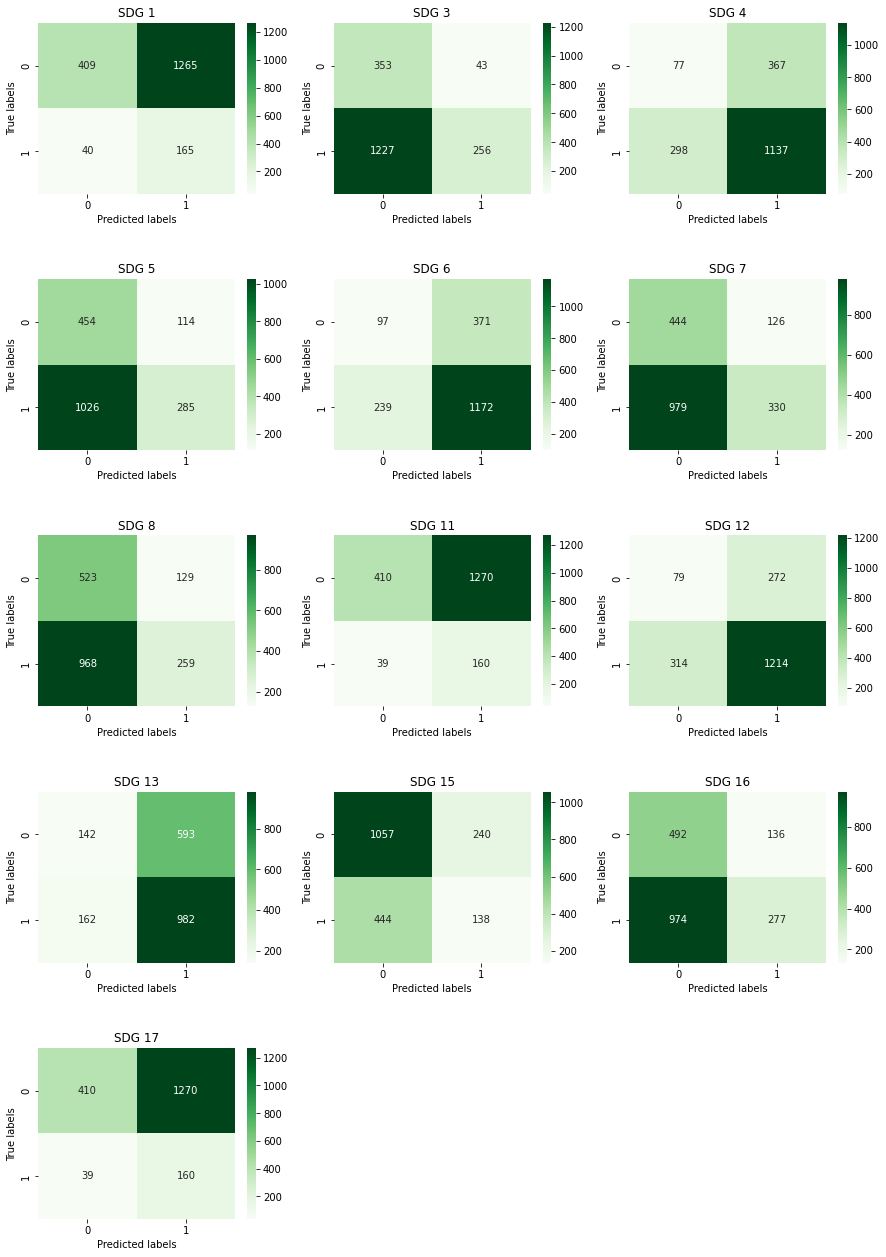

In [15]:
evaluation(grid_svm, outputs_test, Y_test)

### 3.3. Random Forest

In [16]:
np.random.seed(7)

# Pipeline
pipeline = Pipeline([
    ('clf', OneVsRestClassifier(RandomForestClassifier(class_weight="balanced")))
])
    
# Parameters to test in Grid Search
parameters = {
    'clf__estimator__n_estimators': [50, 100], # Number of trees in the forest
    'clf__estimator__max_depth': [10, 20, None] # Maximum depth of the tree
}

# Use stratified sampling in each iteration
stratified_k_fold_cv = IterativeStratification(n_splits=5, order=1)
# Optimize for macro F1-score
scorer = make_scorer(f1_score, average="macro")

# Grid Search
grid_rf = GridSearchCV(pipeline, parameters, cv=stratified_k_fold_cv, scoring=scorer, n_jobs=8, verbose=3)
grid_rf.fit(outputs_train, Y_train)

# Print results
print("Best Parameters: {}".format(grid_rf.best_params_))
print("Mean cross-validated F1-score of the best estimator: {}".format(grid_rf.best_score_))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters: {'clf__estimator__max_depth': 20, 'clf__estimator__n_estimators': 100}
Mean cross-validated F1-score of the best estimator: 0.5128437936602541


              precision    recall  f1-score   support

           0       0.11      0.77      0.20       205
           1       0.78      0.78      0.78      1483
           2       0.76      0.79      0.77      1435
           3       0.71      0.22      0.33      1311
           4       0.77      0.88      0.82      1411
           5       0.73      0.26      0.38      1309
           6       0.66      0.21      0.32      1227
           7       0.11      0.77      0.19       199
           8       0.82      0.80      0.81      1528
           9       0.62      0.86      0.72      1144
          10       0.36      0.23      0.28       582
          11       0.67      0.22      0.33      1251
          12       0.11      0.80      0.20       199

   micro avg       0.54      0.56      0.55     13284
   macro avg       0.55      0.58      0.47     13284
weighted avg       0.68      0.56      0.56     13284
 samples avg       0.48      0.57      0.50     13284



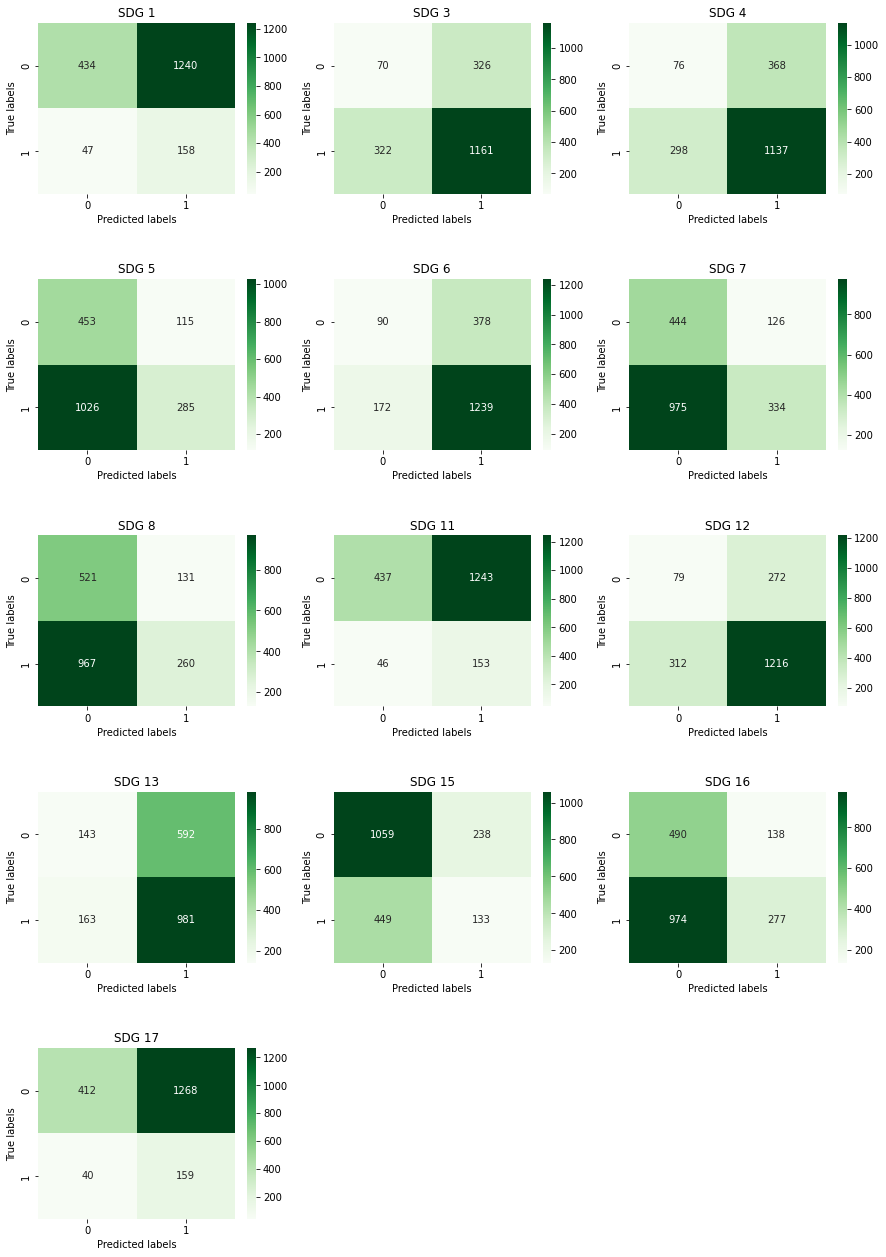

[CV 2/5] END .............clf__estimator__C=0.1;, score=0.466 total time=   2.9s
[CV 4/5] END ..............clf__estimator__C=10;, score=0.442 total time=   1.9s
[CV 5/5] END .............clf__estimator__C=0.1;, score=0.502 total time= 1.2min
[CV 4/5] END ..............clf__estimator__C=10;, score=0.408 total time=  47.4s
[CV 3/5] END clf__estimator__max_depth=10, clf__estimator__n_estimators=50;, score=0.474 total time=   6.0s
[CV 4/5] END clf__estimator__max_depth=10, clf__estimator__n_estimators=100;, score=0.518 total time=  11.4s
[CV 5/5] END clf__estimator__max_depth=20, clf__estimator__n_estimators=100;, score=0.540 total time=  13.2s


/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

[CV 5/5] END .............clf__estimator__C=0.1;, score=0.503 total time=   2.9s
[CV 3/5] END ..............clf__estimator__C=10;, score=0.430 total time=   2.3s
[CV 2/5] END ...............clf__estimator__C=1;, score=0.466 total time= 1.0min
[CV 5/5] END ...............clf__estimator__C=1;, score=0.502 total time=  48.8s
[CV 2/5] END clf__estimator__max_depth=10, clf__estimator__n_estimators=50;, score=0.468 total time=   6.1s
[CV 5/5] END clf__estimator__max_depth=10, clf__estimator__n_estimators=100;, score=0.536 total time=  12.1s
[CV 1/5] END clf__estimator__max_depth=None, clf__estimator__n_estimators=50;, score=0.584 total time=   7.0s
[CV 4/5] END clf__estimator__max_depth=None, clf__estimator__n_estimators=50;, score=0.519 total time=   7.4s


/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

[CV 1/5] END ...............clf__estimator__C=1;, score=0.514 total time=   1.7s
[CV 4/5] END ...............clf__estimator__C=1;, score=0.408 total time=   1.9s
[CV 2/5] END .............clf__estimator__C=0.1;, score=0.466 total time= 1.2min
[CV 5/5] END ..............clf__estimator__C=10;, score=0.502 total time= 1.1min
[CV 3/5] END clf__estimator__max_depth=10, clf__estimator__n_estimators=100;, score=0.436 total time=  11.5s
[CV 4/5] END clf__estimator__max_depth=20, clf__estimator__n_estimators=50;, score=0.409 total time=   7.2s
[CV 2/5] END clf__estimator__max_depth=None, clf__estimator__n_estimators=50;, score=0.467 total time=   7.0s
[CV 5/5] END clf__estimator__max_depth=None, clf__estimator__n_estimators=50;, score=0.541 total time=   7.3s


/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

[CV 3/5] END ...............clf__estimator__C=1;, score=0.430 total time=   3.3s
[CV 1/5] END .............clf__estimator__C=0.1;, score=0.514 total time= 1.1min
[CV 1/5] END ..............clf__estimator__C=10;, score=0.514 total time= 1.0min
[CV 2/5] END clf__estimator__max_depth=10, clf__estimator__n_estimators=100;, score=0.469 total time=  12.5s
[CV 1/5] END clf__estimator__max_depth=20, clf__estimator__n_estimators=100;, score=0.585 total time=  13.9s
[CV 2/5] END clf__estimator__max_depth=None, clf__estimator__n_estimators=100;, score=0.434 total time=  13.1s


/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

[CV 2/5] END ...............clf__estimator__C=1;, score=0.466 total time=   2.0s
[CV 1/5] END ..............clf__estimator__C=10;, score=0.515 total time=   3.2s
[CV 1/5] END ...............clf__estimator__C=1;, score=0.514 total time=  48.3s
[CV 4/5] END ...............clf__estimator__C=1;, score=0.408 total time= 1.3min
[CV 1/5] END clf__estimator__max_depth=10, clf__estimator__n_estimators=100;, score=0.551 total time=  12.1s
[CV 5/5] END clf__estimator__max_depth=20, clf__estimator__n_estimators=50;, score=0.498 total time=   6.9s
[CV 3/5] END clf__estimator__max_depth=None, clf__estimator__n_estimators=50;, score=0.400 total time=   7.1s
[CV 1/5] END clf__estimator__max_depth=None, clf__estimator__n_estimators=100;, score=0.584 total time=  13.7s


/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

[CV 3/5] END .............clf__estimator__C=0.1;, score=0.430 total time=   3.0s
[CV 5/5] END ..............clf__estimator__C=10;, score=0.502 total time=   2.7s
[CV 3/5] END ...............clf__estimator__C=1;, score=0.431 total time= 1.3min
[CV 1/5] END clf__estimator__max_depth=10, clf__estimator__n_estimators=50;, score=0.514 total time=   6.2s
[CV 1/5] END clf__estimator__max_depth=20, clf__estimator__n_estimators=50;, score=0.548 total time=   7.0s
[CV 2/5] END clf__estimator__max_depth=20, clf__estimator__n_estimators=100;, score=0.467 total time=  13.8s
[CV 3/5] END clf__estimator__max_depth=None, clf__estimator__n_estimators=100;, score=0.440 total time=  14.1s
[CV 4/5] END .............clf__estimator__C=0.1;, score=0.408 total time=   2.0s
[CV 5/5] END ...............clf__estimator__C=1;, score=0.502 total time=   1.8s
[CV 3/5] END .............clf__estimator__C=0.1;, score=0.431 total time= 1.2min
[CV 3/5] END ..............clf__estimator__C=10;, score=0.430 total time=  50.

/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jbaumert/miniconda3/envs/ma-jonathan/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

[CV 1/5] END .............clf__estimator__C=0.1;, score=0.515 total time=   2.5s
[CV 2/5] END ..............clf__estimator__C=10;, score=0.466 total time=   2.0s
[CV 4/5] END .............clf__estimator__C=0.1;, score=0.408 total time= 1.1min
[CV 2/5] END ..............clf__estimator__C=10;, score=0.466 total time=  54.4s
[CV 5/5] END clf__estimator__max_depth=10, clf__estimator__n_estimators=50;, score=0.541 total time=   6.7s
[CV 2/5] END clf__estimator__max_depth=20, clf__estimator__n_estimators=50;, score=0.470 total time=   7.5s
[CV 4/5] END clf__estimator__max_depth=20, clf__estimator__n_estimators=100;, score=0.534 total time=  15.1s
[CV 5/5] END clf__estimator__max_depth=None, clf__estimator__n_estimators=100;, score=0.576 total time=  14.2s


In [17]:
evaluation(grid_rf, outputs_test, Y_test)